In [1]:
# !pip install transformers
# !pip install datasets

In [2]:
import gc
import cv2

import numpy as np
import pandas as pd

import tensorflow as tf
from keras.datasets import mnist
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import L1,L2
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from transformers import AutoFeatureExtractor,TFAutoModel

In [3]:
df_train=pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
df_test=pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def preprocess(add_data,three_dimension,expand_shape,resize):
    train_data=np.reshape(df_train.drop(columns=['label']).values,[-1,28,28]).astype('float32')
    train_label=df_train['label'].values
    test_data=np.reshape(df_test.values,[-1,28,28]).astype('float32')

    permutation_index=np.random.permutation(len(train_data))
    train_data=train_data[permutation_index]
    train_label=train_label[permutation_index]
    
    if add_data==True:
        (X_train, y_train), (X_test, y_test) = mnist.load_data()
        train_data=np.concatenate([X_train,X_test,train_data])
        train_label=np.concatenate([y_train,y_test,train_label])

    if three_dimension==True:
        train_data=np.reshape(train_data,[-1,28,28,1]).astype('float32')
        test_data=np.reshape(test_data,[-1,28,28,1]).astype('float32')
        
    if expand_shape==True:
        train_data=np.concatenate([train_data]*3,axis=3)
        test_data=np.concatenate([test_data]*3,axis=3)

    if resize==True:
        train_data=np.asarray([cv2.resize(sample, (32, 32)) for sample in train_data])
        test_data=np.asarray([cv2.resize(sample, (32, 32)) for sample in test_data])

    train_data=train_data/255.0
    test_data=test_data/255.0
    
    print(train_data.shape)
    print(train_label.shape)
    print(test_data.shape)
    
    return train_data,train_label,test_data

In [5]:
train_data,train_label,test_data = preprocess(add_data=True,
                                              three_dimension=True,
                                              expand_shape=False,
                                              resize=False)
train_data,val_data,train_label,val_label=train_test_split(train_data,train_label,train_size=0.95,shuffle=False)

11490434/11490434 [==============================] - 0s 0us/step
(112000, 28, 28, 1)
(112000,)
(28000, 28, 28, 1)


In [6]:
train_data.shape

(106400, 28, 28, 1)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.2,
    shear_range=0.3,
    zoom_range=0.2,
    horizontal_flip=False)

val_datagen = ImageDataGenerator()

In [8]:
tf.keras.backend.clear_session()

# pretrained_model = tf.keras.applications.MobileNetV3Small(
#     weights='imagenet',
#     input_shape=(32, 32, 3),
#     include_top=False,
# #     minimalistic=True
# )
# pretrained_model.count_params()

model=tf.keras.Sequential([
#     layers.MaxPool2D(pool_size=(2,2),strides=(1,1)),
    layers.BatchNormalization(),
    
    layers.Conv2D(8, 3, padding='same', activation='gelu'),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.BatchNormalization(),
#     layers.Dropout(0.1),
    
    layers.Conv2D(24, 3, padding='same', activation='gelu'),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.BatchNormalization(),
#     layers.Dropout(0.1),
    
    layers.Conv2D(48, 3, padding='same', activation='gelu'),
    layers.MaxPool2D(pool_size=(2,2),strides=(2,2)),
    layers.BatchNormalization(),
#     layers.Dropout(0.1),
    
    layers.Flatten(),
#     layers.Dropout(0.1),
    
    layers.Dense(84, activation='relu'),# kernel_initializer='he_normal'),
    layers.BatchNormalization(),
#     layers.Dropout(0.1),
    layers.Dense(10, activation='softmax')
])
# tf.keras.utils.plot_model(model,expand_nested=True, show_shapes=True,show_trainable=True)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

early_stopping=EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    restore_best_weights=False)

lr_schedule=ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=300,
    decay_rate=0.8,
    staircase=True)

lr_reduce = ReduceLROnPlateau(monitor='loss', factor=0.3, verbose=1,
                              min_delta=0.01,
                              patience=5, min_lr=1e-8)

In [10]:
BATCH_SIZE=128
# pretrained_model.train_able=False
optimizer=Adam(learning_rate=lr_schedule,beta_1=0.9, beta_2=0.98,epsilon=1e-9)
model.compile(optimizer=optimizer,
              loss=SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.fit(train_data,train_label,
         validation_data=(val_data,val_label),
          batch_size=BATCH_SIZE,
          callbacks=[early_stopping,lr_reduce],
         epochs=20)

Epoch 1/20
832/832 [==============================] - 55s 63ms/step - loss: 0.0714 - accuracy: 0.9784 - val_loss: 0.0281 - val_accuracy: 0.9918 - lr: 0.0064
Epoch 2/20
832/832 [==============================] - 51s 62ms/step - loss: 0.0224 - accuracy: 0.9928 - val_loss: 0.0159 - val_accuracy: 0.9937 - lr: 0.0033
Epoch 3/20
832/832 [==============================] - 52s 63ms/step - loss: 0.0106 - accuracy: 0.9968 - val_loss: 0.0097 - val_accuracy: 0.9961 - lr: 0.0017
Epoch 4/20
832/832 [==============================] - 52s 62ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 0.0043 - val_accuracy: 0.9986 - lr: 8.5899e-04
Epoch 5/20
832/832 [==============================] - 52s 62ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 8.4731e-04 - val_accuracy: 1.0000 - lr: 5.4976e-04
Epoch 6/20
832/832 [==============================] - 51s 62ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 7.9453e-04 - val_accuracy: 0.9998 - lr: 2.8148e-04
Epoch 7/20
832/832 [==================

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 28, 28, 1)         4         
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 8)         0         
 D)                                                              
                                                                 
 batch_normalization_1 (Bat  (None, 14, 14, 8)         32        
 chNormalization)                                                
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 24)        1752      
                                                        

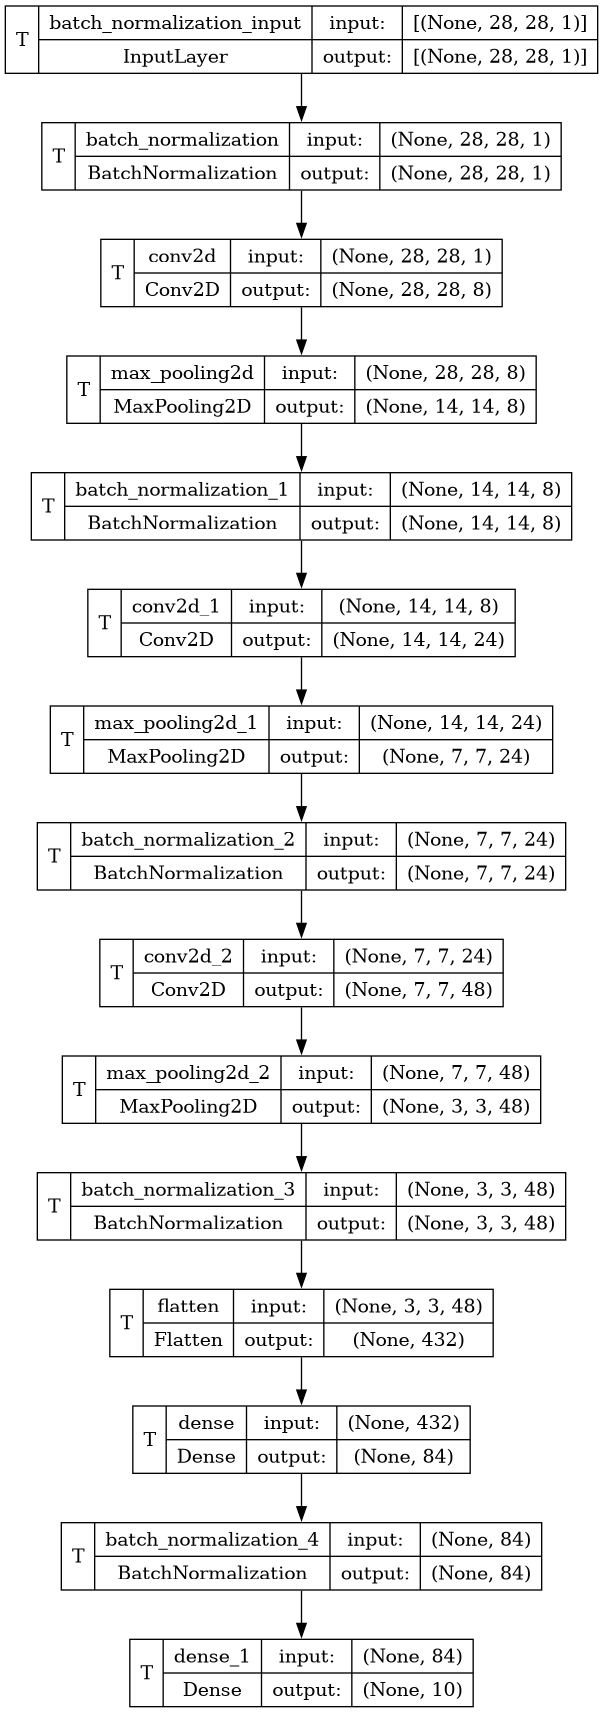

In [11]:
model.summary()
tf.keras.utils.plot_model(model,expand_nested=True, show_shapes=True,show_trainable=True)

In [12]:
preds=np.argmax(model.predict(test_data),axis=1)
submission=pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission['Label']=preds
submission.to_csv('submission.csv',index=False)

875/875 [==============================] - 8s 9ms/step
